## IMPORT NECCESSARY LIBRARY

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

## LOAD DATAFRAME

In [2]:
# dataframe of anime information
df_anime = pd.read_csv('/kaggle/input/anime-rec/data_anime.csv')
df_anime = df_anime.dropna()
df_anime = df_anime[~df_anime.isin(['unknown', 'unknow']).any(axis=1)]


## RANKING ITEM QUALITY 

**Ranking Item Quality** is generally not a recommendation problem, however it plays an importance rule in severals recommendation system. Especially, cold start problem in new user.

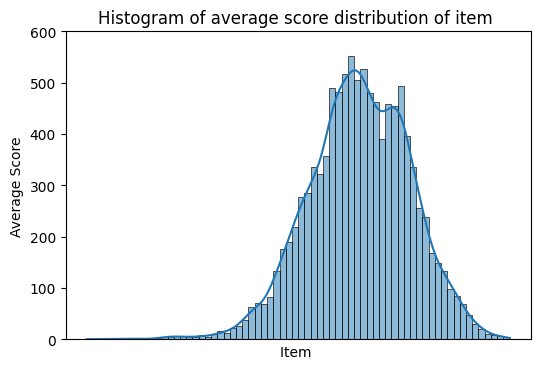

In [3]:
plt.figure(figsize=(6, 4))
sns.histplot(df_anime['Score'], kde= True)
plt.xlabel('Item ')
plt.ylabel("Average Score")
plt.xticks([])
plt.ylim(0,600)
plt.title(f"Histogram of {'average score distribution of item '}")
plt.show()

In [4]:
votes = ['Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
               'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1']
df_votes = df_anime[votes]
df_votes = df_votes.dropna()

df_votes = (
    df_votes
    .replace("unknown", np.nan)          # 1. xử lý unknown
    .apply(pd.to_numeric, errors="coerce")  # 2. ép numeric
    .dropna()                            # 3. xóa NaN
    .astype(int)                         # 4. ép int
)

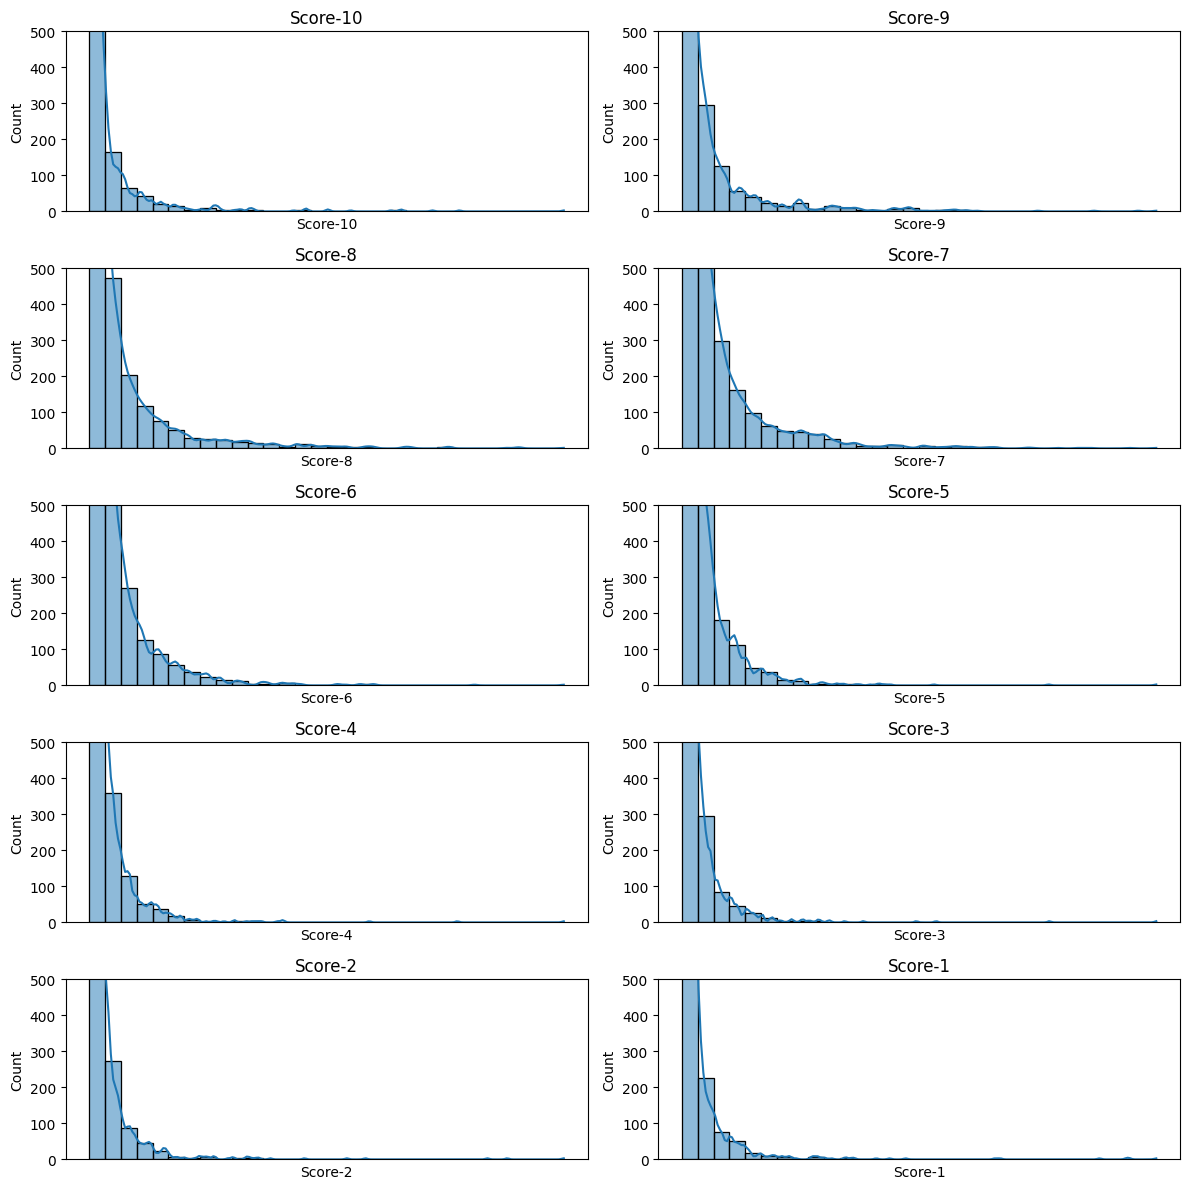

In [5]:
n_cols = 2                  
n_rows = len(votes) // n_cols + (len(votes) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
axes = axes.flatten()

for i, col in enumerate(votes):
    sns.histplot(
        df_votes[col],
        bins=30,
        kde=True,
        ax=axes[i]
    )
    axes[i].set_title(col)

    axes[i].set_ylim(0, 500)
    axes[i].set_xticks([])

# Ẩn subplot dư
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


### 1. Boostrap 

In [6]:
def bootstrap_score(votes, resamples=10000, rng=None):
    votes = votes[::-1]
    if rng is None:
        rng = np.random.default_rng()

    counts = np.array(votes)
    total = counts.sum()

    ratings = np.arange(1, len(votes) + 1)
    probs = counts / total

    mean = np.sum(probs * ratings)
    var = np.sum(probs * (ratings - mean)**2)

    samples = rng.normal(
        loc=mean,
        scale=np.sqrt(var / total),
        size=resamples
    )

    return samples.mean()



In [7]:
df_votes['bootstrap_score'] = df_votes[votes].apply(lambda x: bootstrap_score(x.values), axis = 1)

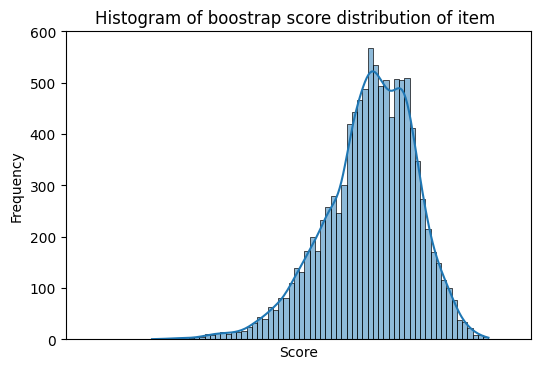

In [8]:
plt.figure(figsize=(6, 4))
sns.histplot(df_votes['bootstrap_score'], kde= True)
plt.xlabel('Score')
plt.ylabel("Frequency")
plt.xticks([])
plt.ylim(0,600)
plt.xlim(0,10)
plt.title(f"Histogram of {'boostrap score distribution of item '}")
plt.show()

### 2. Bayesian Boostrap 

In [9]:
def bayesian_bootstrap_score(votes, resamples=5000, rng=None):
    votes = votes[::-1]
    if rng is None:
        rng = np.random.default_rng()

    counts = np.asarray(votes, dtype=float)
    ratings = np.arange(1, len(counts) + 1)

    # Dirichlet posterior weights
    weights = rng.dirichlet(counts, size=resamples)

    # mỗi row là 1 Bayesian bootstrap sample
    sample_means = weights @ ratings

    return float(sample_means.mean())


In [10]:
print(bayesian_bootstrap_score(df_votes[votes].iloc[0].tolist()))

8.740276230066058


In [12]:
df_votes['BB_Score'] = df_votes[votes].apply(lambda x: bayesian_bootstrap_score(x.values), axis = 1)

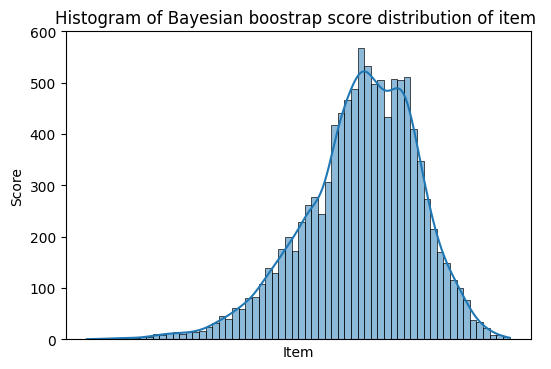

In [14]:
plt.figure(figsize=(6, 4))
sns.histplot(df_votes['BB_Score'], kde= True)
plt.xlabel('Item')
plt.ylabel("Score")
plt.xticks([])
plt.ylim(0,600)
plt.title(f"Histogram of {'Bayesian boostrap score distribution of item '}")
plt.show()

### 3. Dirichlet Posterior 

In [17]:
from scipy.stats import dirichlet

def dirichlet_posterior_score(votes, resamples=2000, alpha=None):
    votes = votes[::-1]
    votes = np.asarray(votes, dtype=float)
    k = len(votes)

    # Prior: uniform nếu không cho
    if alpha is None:
        alpha = np.ones(k)
    alpha = np.asarray(alpha, dtype=float)

    # Posterior
    posterior = alpha + votes
    alpha0 = posterior.sum()

    # Expected rating
    probs_mean = posterior / alpha0
    ratings = np.arange(1, k + 1)
    expected_rating = np.sum(probs_mean * ratings)

    # # Sampling from posterior
    # samples = dirichlet(posterior).rvs(size=resamples)
    # rating_samples = (samples * ratings).sum(axis=1)

    return expected_rating

    

In [18]:
df_votes['DP_Score'] = df_votes[votes].apply(lambda x: dirichlet_posterior_score(x), axis = 1)

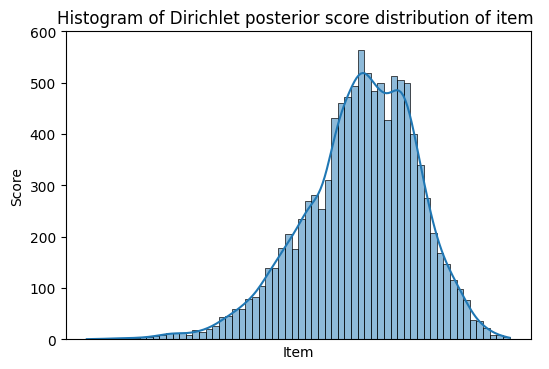

In [20]:
plt.figure(figsize=(6, 4))
sns.histplot(df_votes['DP_Score'], kde= True)
plt.xlabel('Item')
plt.ylabel("Score")
plt.xticks([])
plt.ylim(0,600)
plt.title(f"Histogram of {'Dirichlet posterior score distribution of item '}")
plt.show()

### 4. Comparision Method

**Scatter Corralation**

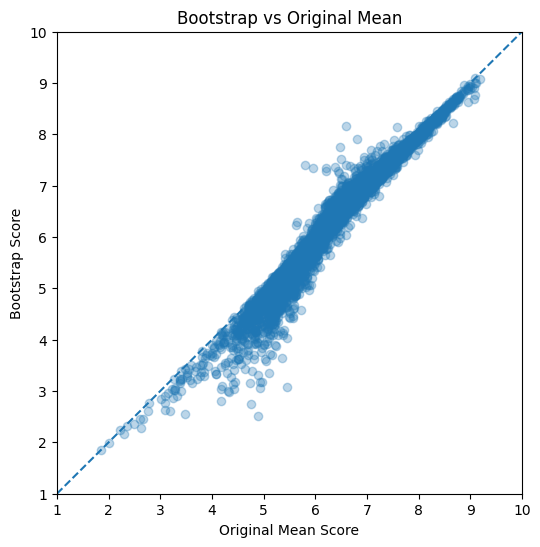

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(
    df_anime['Score'],
    df_votes['bootstrap_score'],
    alpha=0.3
)

plt.plot([1, 10], [1, 10], linestyle='--')  # y = x
plt.xlabel("Original Mean Score")
plt.ylabel("Bootstrap Score")
plt.title("Bootstrap vs Original Mean")
plt.xlim(1, 10)
plt.ylim(1, 10)
plt.show()



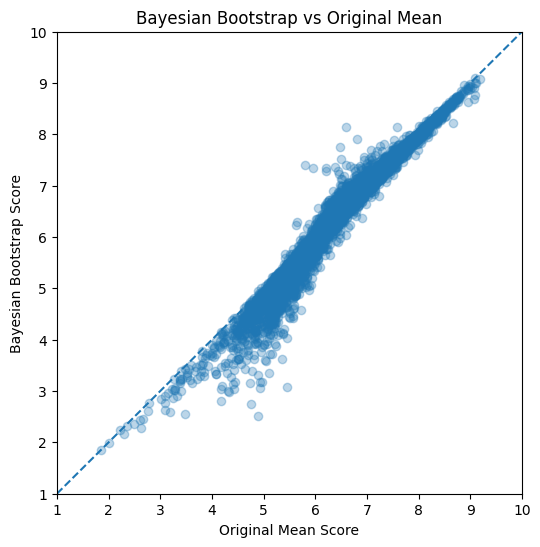

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(
    df_anime['Score'],
    df_votes['BB_Score'],
    alpha=0.3
)

plt.plot([1, 10], [1, 10], linestyle='--')  # y = x
plt.xlabel("Original Mean Score")
plt.ylabel("Bayesian Bootstrap Score")
plt.title("Bayesian Bootstrap vs Original Mean")
plt.xlim(1, 10)
plt.ylim(1, 10)
plt.show()


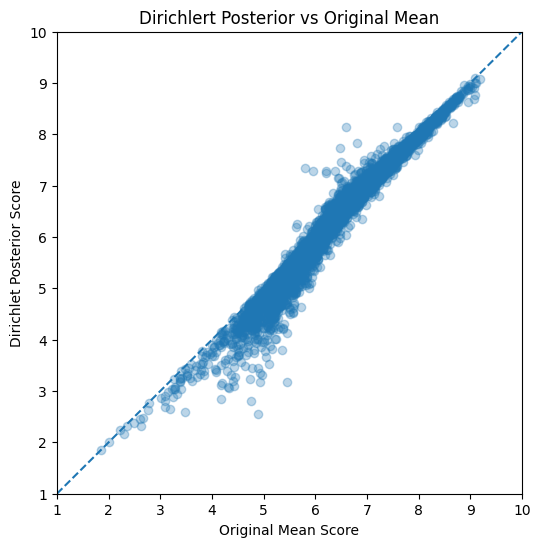

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(
    df_anime['Score'],
    df_votes['DP_Score'],
    alpha=0.3
)

plt.plot([1, 10], [1, 10], linestyle='--')  # y = x
plt.xlabel("Original Mean Score")
plt.ylabel("Dirichlet Posterior Score")
plt.title("Dirichlert Posterior vs Original Mean")
plt.xlim(1, 10)
plt.ylim(1, 10)
plt.show()


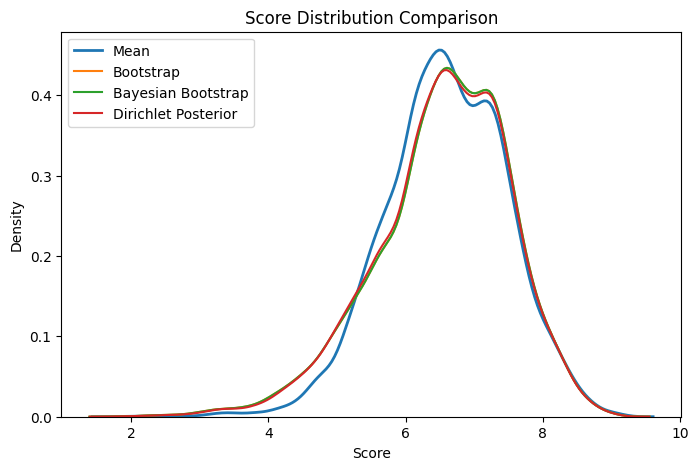

In [27]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.kdeplot(df_anime['Score'], label='Mean', linewidth=2)
sns.kdeplot(df_votes['bootstrap_score'], label='Bootstrap')
sns.kdeplot(df_votes['BB_Score'], label='Bayesian Bootstrap')
sns.kdeplot(df_votes['DP_Score'], label='Dirichlet Posterior')

plt.xlabel("Score")
plt.title("Score Distribution Comparison")
plt.legend()
plt.show()
